# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download Face and signature-verification Dataset<a class="anchor" id="1a">

In [2]:
import opendatasets as od 
import pandas 

od.download('https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/data')
!mv att-database-of-faces faces
!mv faces data/faces
  


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/kasikrit/att-database-of-faces


100%|██████████| 3.61M/3.61M [00:00<00:00, 4.03MB/s]


In [3]:
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 
!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mallapraveen/signature-matching


100%|██████████| 468M/468M [07:27<00:00, 1.10MB/s] 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### Face Dataset<a class="anchor" id="1b">

In [34]:
class SiameseDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform
        
    def __getitem__(self, index):
        index = self.indices[index]
        img0_tuple = self.dataset.imgs[index]

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.indices)

In [35]:
# Define Dataset Folder
face_folder_dataset = datasets.ImageFolder(root="./data/faces/")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(face_folder_dataset))
valid_size = int(0.1 * len(face_folder_dataset))
test_size = len(face_folder_dataset) - train_size - valid_size
face_train_dataset, face_valid_dataset, face_test_dataset = torch.utils.data.random_split(face_folder_dataset, [train_size, valid_size, test_size])

# Define the transformations for train, validation, and test
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply the transformations
face_train_dataset = SiameseDataset(subset=face_train_dataset, transform=train_transform)
face_valid_dataset = SiameseDataset(subset=face_valid_dataset, transform=valid_test_transform)
face_test_dataset = SiameseDataset(subset=face_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")

Number of training samples: 320
Number of validation samples: 40
Number of testing samples: 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


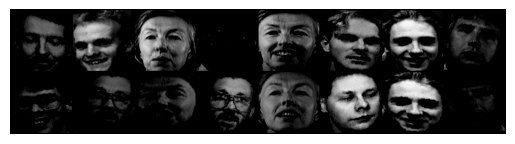

[1. 1. 0. 1. 0. 1. 0. 0.]


In [36]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Signature Dataset<a class="anchor" id="1b">

In [37]:
# import pandas as pd
# import os
# import PIL
# class SignatureNetworkDataset(Dataset):
#     def __init__(self, imageFolderDataset, transform=None):        
#         self.transform = transform
#         self.imageFolderDataset = imageFolderDataset
#         self.original_images = [img for img in self.imageFolderDataset.imgs if img[1] % 2 == 0]
#         self.forged_images = [img for img in self.imageFolderDataset.imgs if img[1] % 2 == 1]       


#     def __getitem__(self, idx):
#         img0_tuple = random.choice(self.original_images)

#         #We need to approximately 50% of images to be in the same class        
#         should_get_same_class = random.randint(0,1) 
        
#         if should_get_same_class:
#             while True:
#                 # Find second image of same class, not forged
#                 img1_tuple = random.choice(self.original_images) 
#                 if img0_tuple[1] == img1_tuple[1]:
#                     break
            
#         else:
#             while True:
#             #Look untill a different class image is found
#                 img1_tuple = random.choice(self.forged_images) 
#                 if img0_tuple[1] != img1_tuple[1]:
#                     break

#         img0 = Image.open(img0_tuple[0])
#         img1 = Image.open(img1_tuple[0])

#         img0 = img0.convert("L")
#         img1 = img1.convert("L")

#         if self.transform is not None:
#             img0 = self.transform(img0)
#             img1 = self.transform(img1)
        
#         return img0, img1, torch.from_numpy(np.array([should_get_same_class], dtype=np.float32))
        
#     def __len__(self):
#         return len(self.imageFolderDataset.imgs)

In [38]:
# Define Dataset Folder
signature_folder_dataset = datasets.ImageFolder(root="./data/signature/full")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(signature_folder_dataset))
valid_size = int(0.1 * len(signature_folder_dataset))
test_size = len(signature_folder_dataset) - train_size - valid_size
signature_train_dataset, signature_valid_dataset, signature_test_dataset = torch.utils.data.random_split(signature_folder_dataset, [train_size, valid_size, test_size])

# Define the transformations for train, validation, and test
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply the transformations
signature_train_dataset = SiameseDataset(subset=signature_train_dataset, transform=train_transform)
signature_valid_dataset = SiameseDataset(subset=signature_valid_dataset, transform=valid_test_transform)
signature_test_dataset = SiameseDataset(subset=signature_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 3431
Number of validation samples: 428
Number of testing samples: 430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


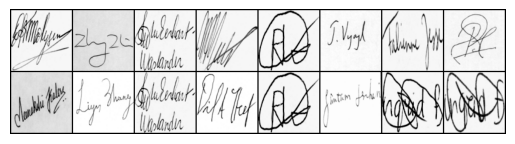

[1. 1. 0. 1. 0. 1. 1. 1.]


In [39]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_test_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [40]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 0
 Current loss 8.156086921691895

Validation loss after 10 iterations: 11.153178215026855

Epoch number 1
 Current loss 8.337343215942383

Validation loss after 20 iterations: 9.860870361328125

Epoch number 2
 Current loss 8.489458084106445

Validation loss after 30 iterations: 14.088086128234863

Epoch number 3
 Current loss 7.52476167678833

Validation loss after 40 iterations: 10.378188133239746

Epoch number 4
 Current loss 7.690768718719482

Validation loss after 50 iterations: 12.18500804901123

Epoch number 5
 Current loss 8.738899230957031

Validation loss after 60 iterations: 15.147994041442871

Epoch number 6
 Current loss 7.629338264465332

Validation loss after 70 iterations: 8.960711479187012

Epoch number 7
 Current loss 7.295764923095703

Validation loss after 80 iterations: 10.769721031188965

Epoch number 8
 Current loss 8.85072135925293

Validation loss after 90 iterations: 11.7009916305542

Epoch number 9
 Current loss 7.591734886169434

Validation los

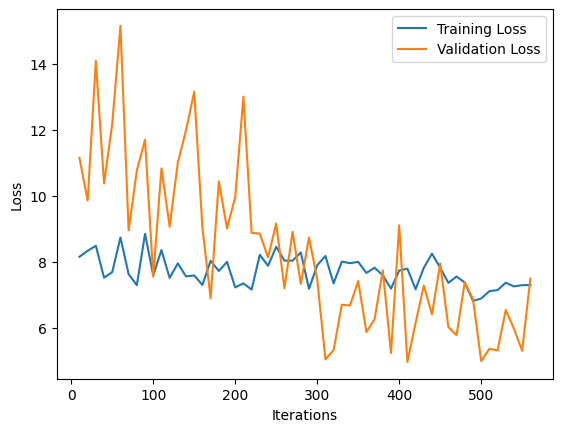

saved model checkpoint


In [49]:
import SiameseNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)
face_test_loader = DataLoader(face_test_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.00001)
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 100, patience=15)

checkpoint = {'model_state_dict': face_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/face_net2.pt')
print('saved model checkpoint')

Epoch number 0
 Current loss 8.288613319396973

Validation loss after 10 iterations: 11.278072357177734

Epoch number 0
 Current loss 11.597373962402344

Validation loss after 20 iterations: 12.437725067138672

Epoch number 0
 Current loss 10.796314239501953

Validation loss after 30 iterations: 11.242053985595703

Epoch number 1
 Current loss 8.470130920410156

Validation loss after 40 iterations: 8.798004269599915

Epoch number 1
 Current loss 7.805117607116699

Validation loss after 50 iterations: 6.702117562294006

Epoch number 1
 Current loss 7.666046142578125

Validation loss after 60 iterations: 6.962095737457275

Epoch number 2
 Current loss 8.044393539428711

Validation loss after 70 iterations: 5.652334809303284

Epoch number 2
 Current loss 5.718504428863525

Validation loss after 80 iterations: 4.909061133861542

Epoch number 2
 Current loss 5.367193222045898

Validation loss after 90 iterations: 4.640944600105286

Epoch number 3
 Current loss 6.778716087341309

Validation 

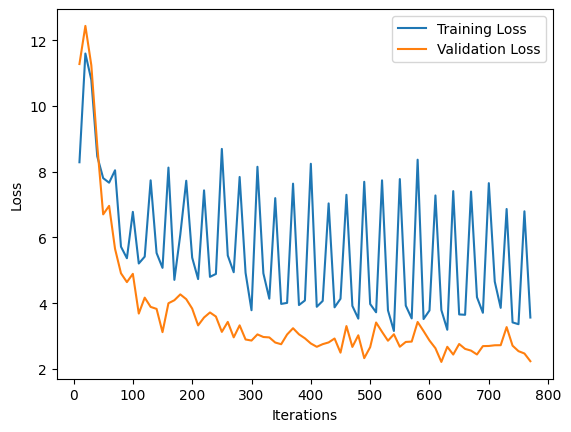

saved model checkpoint


In [50]:
signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=128)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=128)

signature_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()

optimizer = optim.Adam(signature_net.parameters(), lr = 0.00001)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, criterion, epochs=100, patience=15)


checkpoint = {'model_state_dict': signature_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/signature_net.pt')
print('saved model checkpoint')

In [51]:
import SiameseNetwork

face_net = SiameseNetwork.SiameseNetwork().cuda()
face_model_path = f"./checkpoints/face_net.pt"
face_state_dict = torch.load(face_model_path)
face_net.load_state_dict(face_state_dict['model_state_dict'])

signature_net = SiameseNetwork.SiameseNetwork().cuda()
signature_model_path = f"./checkpoints/signature_net.pt"
signature_state_dict = torch.load(face_model_path)
signature_net.load_state_dict(signature_state_dict['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.9372549].


face distance tensor([0.8268], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


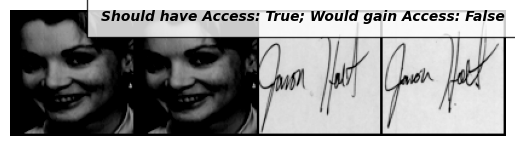

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


face distance tensor([0.1258], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


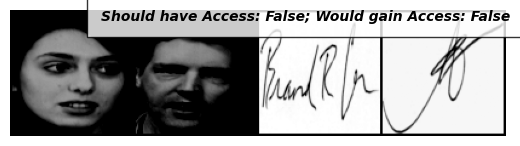

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.96862745].


face distance tensor([0.9226], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


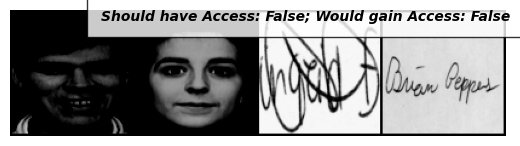

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70980394..1.0].


face distance tensor([0.9768], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


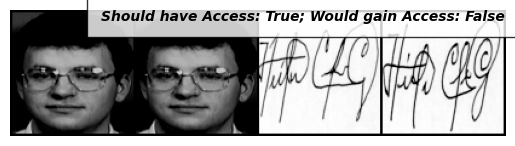

face distance tensor([0.2702], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


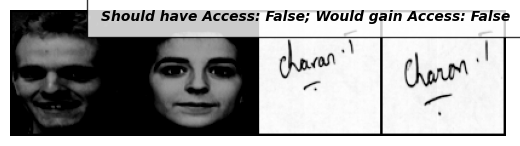

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.96862745].


face distance tensor([1.7769], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


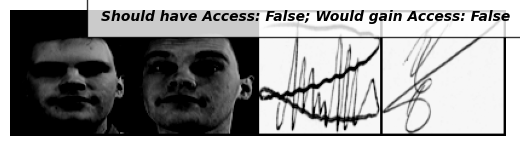

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


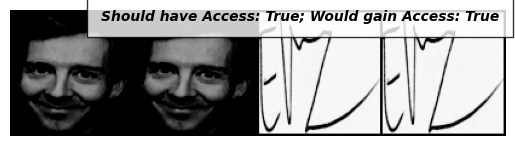

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.96862745].


face distance tensor([1.7487], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


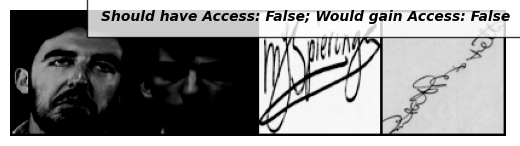

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


face distance tensor([0.2328], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


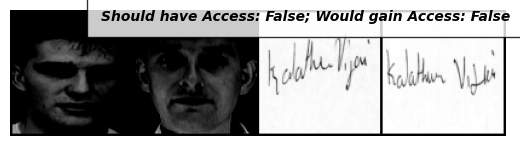

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.99215686].


face distance tensor([0.8218], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


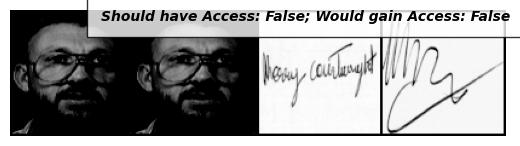

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


face distance tensor([2.3065], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


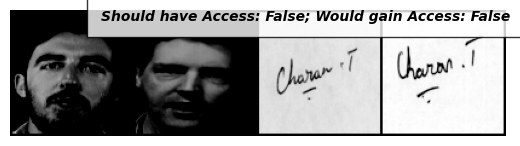

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..1.0].


face distance tensor([2.3192], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


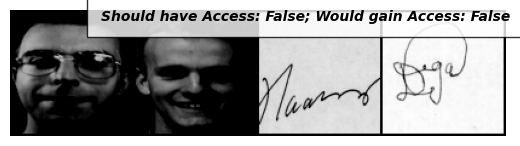

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.99215686].


face distance tensor([0.8838], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


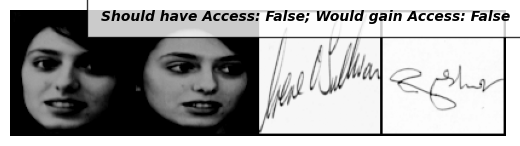

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].


face distance tensor([0.3793], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


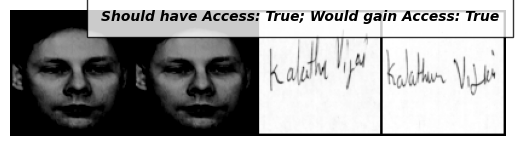

face distance tensor([0.9305], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


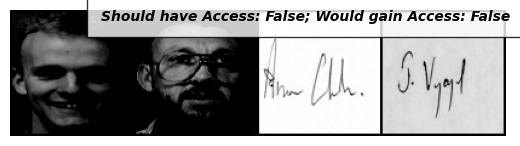

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


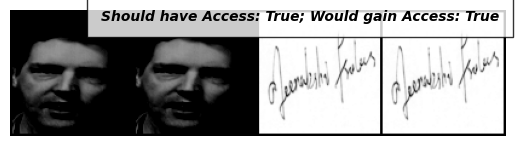

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.8980392].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


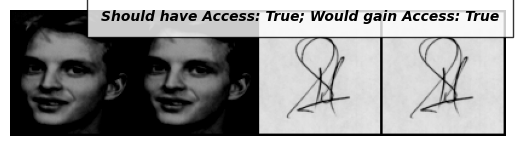

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..1.0].


face distance tensor([0.0685], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


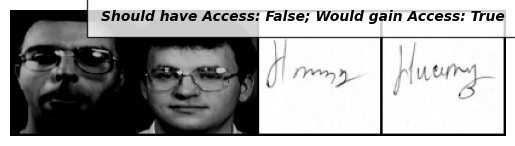

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.9843137].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


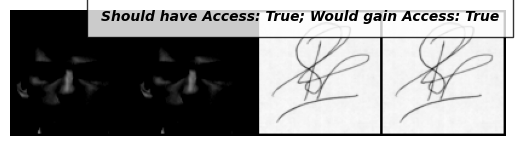

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.96862745].


face distance tensor([0.8150], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


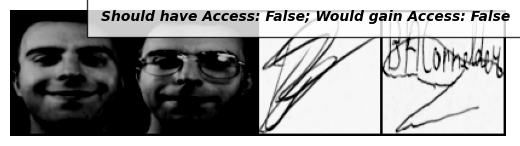

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([0.7172], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


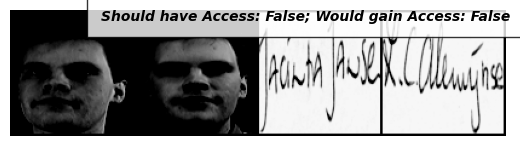

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.92156863].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


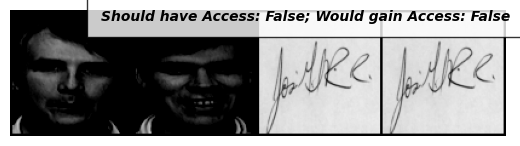

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.92941177].


face distance tensor([0.2281], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


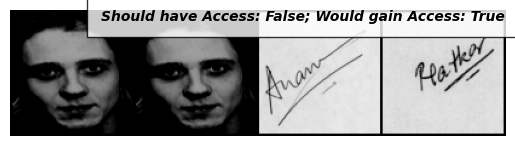

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.99215686].


face distance tensor([0.7547], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


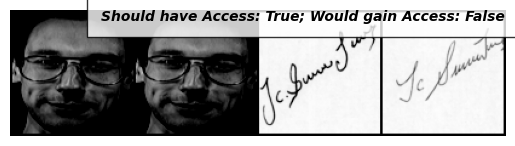

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.99215686].


face distance tensor([0.3638], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


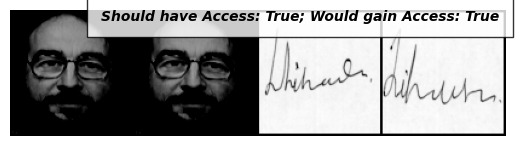

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9137255].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


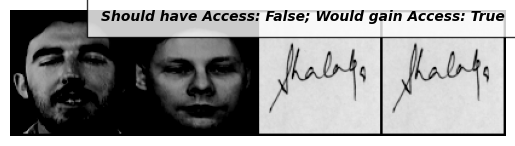

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.96862745].


face distance tensor([2.4720], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


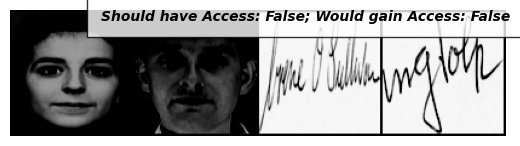

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.96862745].


face distance tensor([0.4942], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


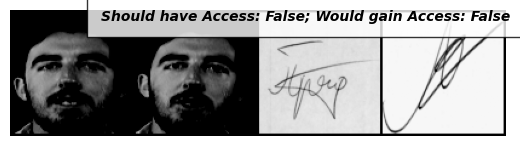

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.9137255].


face distance tensor([0.8807], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


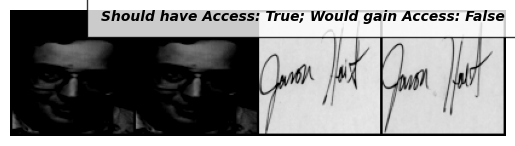

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


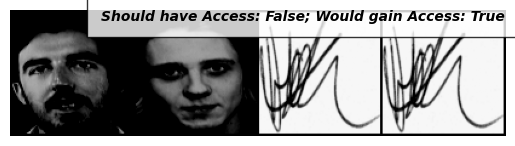

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


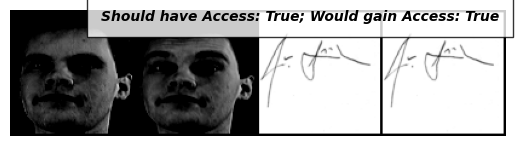

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


face distance tensor([1.7925], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


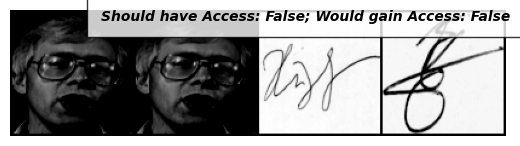

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


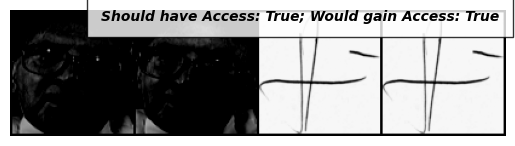

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.96862745].


face distance tensor([0.5497], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


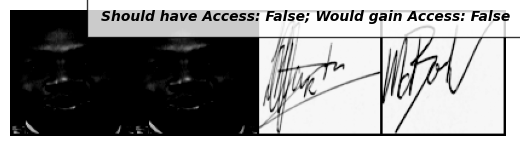

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.9137255].


face distance tensor([0.1069], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


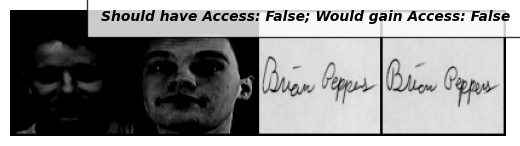

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.96862745].


face distance tensor([1.6298], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


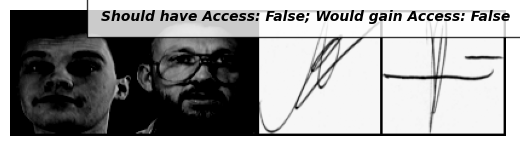

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.96862745].


face distance tensor([0.9928], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


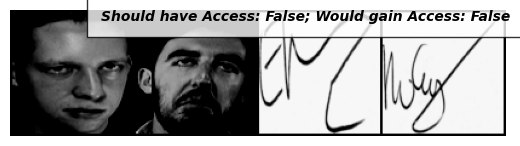

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.90588236].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


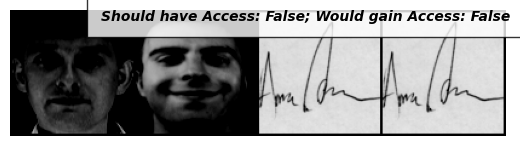

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


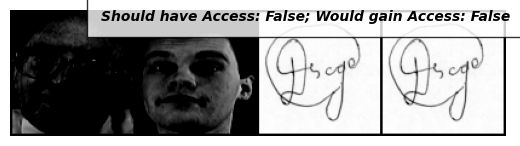

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.9372549].


face distance tensor([2.9891], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


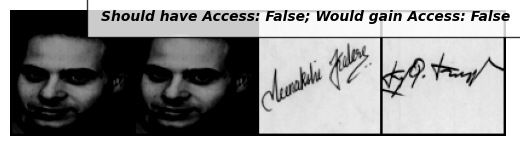

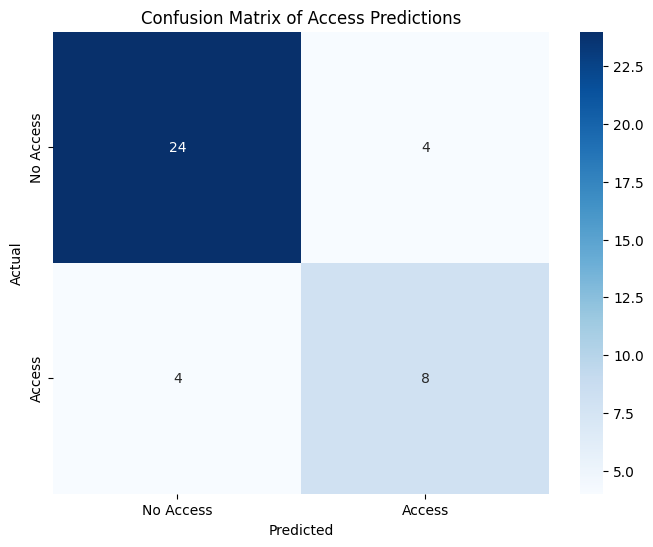

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Locate the test dataset and load it into the SiameseNetworkDataset
face_net.eval()
signature_net.eval()

face_test_dataloader = DataLoader(face_test_dataset, num_workers=2, batch_size=1, shuffle=True)
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=1)

# Grab one image that we are going to test
face_dataiter = iter(face_test_dataloader)
signature_dataiter = iter(signature_test_loader)

should_have_access_list = []
would_gain_access_list = []

for i in range(len(face_test_dataloader)):
    # Iterate over 5 images and test them with the first image (x0)
    face0, face1, face_label = next(face_dataiter)
    signature1, signature2, forge_label = next(signature_dataiter)

    face_output1, face_output2 = face_net(face0.cuda(), face1.cuda())
    euclidean_distance = F.pairwise_distance(face_output1, face_output2)
    #print(f"face distance {euclidean_distance}; label {face_label}")
    face_distance = (euclidean_distance < 1.5).bool()

    signature_output1, signature_output2 = signature_net(signature1.cuda(), signature2.cuda())
    #print(torch.sigmoid(forgery_output).bool())
    euclidean_distance = F.pairwise_distance(signature_output1, signature_output2)
    print(f"face distance {euclidean_distance}; label {forge_label}")

    signature_distance = (euclidean_distance < 0.4).bool()
    
    # Concatenate the two images together
    concatenated = torch.cat((face0, face1, signature1, signature2), 0)
    would_gain_access = face_distance.cpu()[0] and signature_distance.cpu()[0]
    should_have_access = not face_label.cpu()[0][0].bool() and not forge_label.cpu()[0][0].bool() 
    should_have_access_list.append(should_have_access)
    would_gain_access_list.append(would_gain_access)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Should have Access: {should_have_access}; Would gain Access: {would_gain_access}')


# Create confusion matrix
conf_matrix = confusion_matrix(should_have_access_list, would_gain_access_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Access', 'Access'], yticklabels=['No Access', 'Access'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Access Predictions')
plt.show()